In [5]:
# # Con esto funciona, quizas algo sobra
# !pip install -Uqq fastbook
# !pip install fastai==2.0
# import fastai
# print(fastai.__version__)
# import fastbook
# from fastai.vision.all import *

### De imagenes a tensores, visualizando, de lista de tensores a tensor de tensores (stacking), concatenando, .abs(), .mean(), .float(), .item(), calculando accuracy y loss a mano

In [7]:
path = untar_data(URLs.MNIST_SAMPLE)

In [8]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/valid')]

In [9]:
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/7'),Path('/root/.fastai/data/mnist_sample/train/3')]

In [10]:
train3 = sorted((path/'train'/'3').ls())
train7 = sorted((path/'train'/'7').ls())

In [11]:
import PIL
from PIL import Image

im3_path = train3[1]
im3 = Image.open(im3_path)
im3

In [12]:

from PIL import Image
from torchvision.transforms import ToTensor

image = Image.open(im3_path)
image = ToTensor()(image)

In [13]:
image.shape

torch.Size([1, 28, 28])

In [14]:
train7_images = [Image.open(path) for path in train7]
train7_images[0]

In [15]:
# lista de tensors
train7_tensors = [ToTensor()(img).squeeze() for img in train7_images]

# stack them up in a tensor of tensors
stacked_train7 = torch.stack(train7_tensors).float()

In [16]:
# same with threes
train3_images = [Image.open(path) for path in train3]
train3_tensors = [ToTensor()(img).squeeze() for img in train3_images]
stacked_train3 = torch.stack(train3_tensors).float()

In [17]:
# shapes
stacked_train7.shape, stacked_train3.shape

(torch.Size([6265, 28, 28]), torch.Size([6131, 28, 28]))

In [18]:
# means

mean3 = stacked_train3.mean(0)
mean7 = stacked_train7.mean(0)

mean3.shape, mean7.shape

# mean3 = mean3.unsqueeze_(2)
# mean3.shape

(torch.Size([28, 28]), torch.Size([28, 28]))

In [19]:
# show_image(mean3.permute(2,1,0))

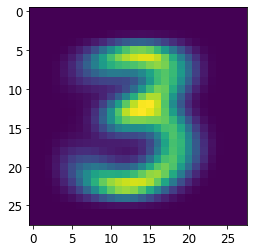

In [20]:
from matplotlib import pyplot as plt
plt.imshow(mean3)

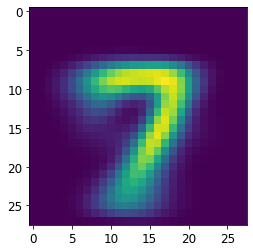

In [21]:
from matplotlib import pyplot as plt
plt.imshow(mean7)

Ahora tenemos que medir la distancia entre nuestro validation set y nuestros numeros ideal

In [22]:
valid3 = sorted((path/'valid'/'3').ls())
valid7 = sorted((path/'valid'/'7').ls())

In [23]:
valid3[:2]

[Path('/root/.fastai/data/mnist_sample/valid/3/1020.png'),
 Path('/root/.fastai/data/mnist_sample/valid/3/1028.png')]

In [24]:
valid3_images = [Image.open(path) for path in valid3]
valid3_tensors = [ToTensor()(img) for img in valid3_images]
stacked_valid3 = torch.stack(valid3_tensors).float()
stacked_valid3.squeeze_()

valid7_images = [Image.open(path) for path in valid7]
valid7_tensors = [ToTensor()(img) for img in valid7_images]
stacked_valid7 = torch.stack(valid7_tensors).float()
stacked_valid7.squeeze_();

In [25]:
stacked_valid3.shape, stacked_valid7.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [26]:
stacked_valid3[0][10]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6392, 0.9961, 0.1804, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])

mean squared error

In [27]:
(stacked_valid3 - mean3).abs().mean() # no importa diferente shape porque broadcasting


# esto no me sirve porque yo no quiero una media de todo el validation set, sino de cada imagen
# para poder clasificar cada imagen. Entonces la media no tiene que ser calculada para todos los pixeles del ser
# la media tiene que ser calculada a lo largo de los ejes 28,28, por eso la celda siguiente

tensor(0.1296)

In [28]:
(stacked_valid3 - mean3).abs().mean((-1,-2)) # promedio de ultimo y anteultimos ejes. Me da un numero por imagen

tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260])

root mean squared error

In [29]:
((stacked_valid3 - mean3)**2).mean((-1,-2)).sqrt() # no importa diferente shape porque broadcasting

tensor([0.2328, 0.2883, 0.2277,  ..., 0.2724, 0.2321, 0.2282])

In [30]:
# arbitrary 3
a_3 = stacked_train3[1]

# distance using L1 norm or mean absolute error
dist_3_abs = (a_3 - mean3).abs().mean()

# distance using L2norm or root mean squared error (RMSE)
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()

dist_3_abs,dist_3_sqr
# >>(tensor(0.1114), tensor(0.2021))

dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

funcion de la distancia, usand mae

In [31]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))

In [32]:
mnist_distance(a_3, mean3) # funciona ok

tensor(0.1114)

In [33]:
mnist_distance(stacked_valid3, mean3)

tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260])

In [34]:
valid_3_dist = mnist_distance(stacked_valid3, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260]),
 torch.Size([1010]))

funcion que decide si una imagen es 3 o 7 usando este el mean absolute error

In [35]:
def is_3(a): return mnist_distance(a,mean3) < mnist_distance(a,mean7)

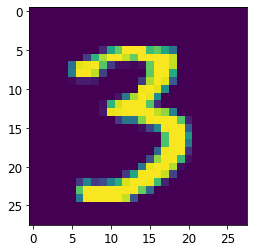

In [36]:
plt.imshow(a_3)

In [39]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [40]:
is_3(stacked_valid3)

tensor([ True,  True,  True,  ..., False,  True,  True])

— Ahora podemos calcular la accuracy promedio en nuestros validation sets



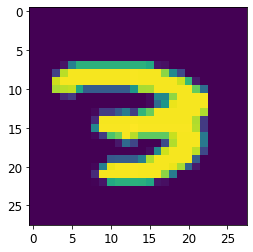

In [41]:
plt.imshow(stacked_valid3[15])

In [42]:
accuracy3 = is_3(stacked_valid3).float().mean()
accuracy7 = (1 - is_3(stacked_valid7).float()).mean()
avg_accs = (accuracy3 + accuracy7)/2

In [43]:
accuracy3, accuracy7, avg_accs

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

### Datasets, modelo lineal, y accuracy de predicciones

**Ahora creamos training set y validation set, y eso es lo que vamos a usar**


In [44]:
train_x = torch.cat([stacked_train3, stacked_train7])

In [45]:
train_x.shape

torch.Size([12396, 28, 28])

en vez de lista de matrices, queremos lista de vectores, entonces transformamos la forma de train_x

In [46]:
train_x = train_x.view(-1, 28*28);

In [47]:
train_x.shape

torch.Size([12396, 784])

In [48]:
train_y = tensor([1. for n in range(len(stacked_train3))] + [0. for n in range(len(stacked_train7))])

# # si no pusieramos ese tensor delante de la lista, tendriamos que transf lista en tensor asi:
# train_y = torch.FloatTensor(train_y)

# necesitamos que tenga una dimension mas
train_y.unsqueeze_(1);

In [49]:
train_y.shape

torch.Size([12396, 1])

In [50]:
# forma mas suscinta, como esta en el libro
# aca no hay ninguna lista, crea directamente un tensor
train_y = tensor( [1]*len(train3) + [0]*len(train7) ).unsqueeze(1)

Ahora podemos crear **datasets**

In [51]:
train_dset = list(zip(train_x, train_y))
x,y = train_dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [52]:
# same for validation set
valid_x = torch.cat((stacked_valid3, stacked_valid7))
valid_x = valid_x.view(-1,28*28)
valid_x.shape

torch.Size([2038, 784])

In [53]:
valid_y = tensor( [1] * len(valid3) + [0] * len(valid7) ).unsqueeze(1)

In [54]:
valid_y.shape

torch.Size([2038, 1])

In [55]:
valid_dset = list(zip(valid_x, valid_y))

In [56]:
x, y = valid_dset[0]
x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

**Ahora crear nuestro modelo (lineal), y vemos accuracy**

In [57]:
# para inicializar parametros

def init_params(size, std=1.0): 
    return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28,1))
bias = init_params(1)

In [58]:
weights.shape

torch.Size([784, 1])

In [59]:
# modelo

def linear1(xb): return xb@weights + bias

# predicciones

preds = linear1(train_x)
preds.shape, train_y.shape

(torch.Size([12396, 1]), torch.Size([12396, 1]))

In [60]:
preds

tensor([[ -6.2330],
        [-10.6388],
        [-20.8865],
        ...,
        [-15.9176],
        [ -1.6866],
        [-11.3568]], grad_fn=<AddBackward0>)

In [61]:
# check accuracy
# supongo que tambien podria ser preds > 0.5
corrects = (preds>0.0).float() == train_y
           # True      1        1      -- True
           # True      1        0      -- False
           # False     0        0      -- True
           # True      1        0      -- False
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [62]:
acc = corrects.float().mean().item()
acc

0.5379961133003235

A very small change in the value of a weight will often not actually change the accuracy at all. This means it is not useful to use accuracy as a loss function—if we do, most of the time our gradients will actually be 0, and the model will not be able to learn from that number

Basicamente accuracy no sirve para loss function, asi que veremos una mejor

### Training model From Scratch

Ahora veamos como seria crear **dataloaders** y gestionar SGD por nuestra cuenta

In [63]:
# dataloaders

train_dl = DataLoader(train_dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)
# grab single batch example

xb, yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [64]:
# necesitamos loss function (distinta de accuracy)

def mnist_loss(predictions, targets):
  predictions = predictions.sigmoid()   # porque necesitamos outputs entre 0 y 1

  return torch.where(targets==1, 1-predictions, predictions).mean()

# torch.where( if condition, return this, else this)

In [65]:
# Function to calculate gradients

def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [66]:
# Training loop for each epoch
def train_epoch(model, lr, params):
    for xb,yb in train_dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

""" obs: assigning to the data attribute of a tensor, 
PyTorch will not take the gradient of that step. """

' obs: assigning to the data attribute of a tensor, \nPyTorch will not take the gradient of that step. '

In [67]:
# function to calculate accuracy in a batch
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb    # obs: True == 1  >>True
    return correct.float().mean()


In [68]:
# function to calculate accuracy in all validation set (using batches)
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [69]:
# con esto ya podemos entrenar y chequear accuracy por un numero de epocas
lr = 1.
params = weights,bias
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.7304 0.8506 0.9009 0.9292 0.9389 0.9443 0.9526 0.9546 0.9589 0.9614 0.9624 0.9624 0.9633 0.9638 0.9648 0.9663 0.9668 0.9672 0.9672 0.9677 

### Training model Con optimizer y nn.Linear module

Ahora vamos a usar un **optimizer** y los **paquetitos** que ya vienen hechos para todas estas cosas

In [70]:
# Our model now 

linear_model = nn.Linear(28*28,1) # crea random params en un linear model

# podes acceder a los parametros del modelo
w,b = linear_model.parameters()

w.shape, b.shape
# >> (torch.Size([1, 784]), torch.Size([1]))

(torch.Size([1, 784]), torch.Size([1]))

In [72]:
# Para el Optimizer usamos esta clase
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

# creamos optimizer para nuestro modelo
opt = BasicOptim(linear_model.parameters(), lr)

# Training loop "simplificado"
def train_epoch(model):
    for xb,yb in train_dl:
        calc_grad(xb, yb, model)
        opt.step()                 # solo esto cambia. Usamos metodos del optimizer en lugar de codigo explicito.
        opt.zero_grad()            # antes: "for p in params: p.data -= p.grad*lr, p.grad.zero_()

# same validation function
validate_epoch(linear_model)

# Ponemos al training loop en una funcion solo para que quede mejor
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

# usamos nuestra funcion
train_model(linear_model, 20)

0.4932 0.8159 0.8501 0.9141 0.9321 0.9463 0.9555 0.9634 0.9658 0.9673 0.9692 0.9712 0.9736 0.9746 0.9761 0.9765 0.9775 0.9775 0.978 0.978 

### Training model Usando fastai's Learner and fit method

In [ ]:
# # Con esto funciona, quizas algo sobra
# !pip install -Uqq fastbook
# !pip install fastai==2.0
# import fastai
# print(fastai.__version__)
# import fastbook
# from fastai.vision.all import *


Asi se crea un Learner sin usar cnn_Learner (y equivalentes)

In [73]:
# Dataloaders: Basic wrapper around several DataLoaders.
dls = DataLoaders(train_dl, valid_dl)

# Learner

learn = Learner(dls,
                nn.Linear(28*28,1),     # el modelo
                opt_func=SGD,           # SGD by default es igual a BasicOptim
                loss_func=mnist_loss,
                metrics=batch_accuracy  # metrics
)

y podemos ahora usar .fit en lugar de train_model

In [74]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636993,0.503383,0.495584,00:00
1,0.490274,0.215135,0.806673,00:00
2,0.181599,0.170885,0.844455,00:00
3,0.080432,0.103082,0.914132,00:00
4,0.043100,0.076113,0.933268,00:00
5,0.028479,0.061395,0.947988,00:00
6,0.022438,0.052155,0.955348,00:00
7,0.019722,0.045967,0.963199,00:00
8,0.018323,0.041594,0.965653,00:00
9,0.017473,0.038358,0.967615,00:00


Y asi es como develamos que hay detras de los paquetitos de fastai. Ahora podemos confiar.
